<a href="https://colab.research.google.com/github/5levic/Fastai-course/blob/main/Chapter_2_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We will create a flower classification algorithm

This data set contains images of flowers from 102 different species. We will build a simple model which will allow to claddify theses images.

### 1. First we import all necessary tools

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.widgets import *
!pip install opendatasets
import opendatasets as od
import zipfile
import json
from pathlib import Path

     |████████████████████████████████| 720 kB 7.1 MB/s 
     |████████████████████████████████| 189 kB 69.6 MB/s 
     |████████████████████████████████| 48 kB 6.6 MB/s 
     |████████████████████████████████| 1.2 MB 55.3 MB/s 
     |████████████████████████████████| 55 kB 5.2 MB/s 
     |████████████████████████████████| 561 kB 53.1 MB/s 
     |████████████████████████████████| 51 kB 399 kB/s 
     |████████████████████████████████| 130 kB 66.8 MB/s 


### 2. Downloading and unziping the flower dataset

In [4]:
od.download("https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip")

311443456it [00:05, 60040648.25it/s]                               


In [5]:
!mkdir flowers
with zipfile.ZipFile('/content/flower_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/flowers')

Checking if all images are valid - all can be opened:

In [7]:
failed = verify_images('/content/flowers/flower_data')

### 2. Creating a Fastai model

First we will creat a function which generates the label for each image.

In [4]:
def label_func(x):
  with open('/content/drive/MyDrive/Colab Notebooks/cat_to_name.json') as raw_file:
    json_str = raw_file.read()
    dict_label = json.loads(json_str)
  return dict_label[str(Path(x).parent.name)]

Secondly we will creat a DataLoader object that will provide batches of training and validation images a few items at a time (64) to the GPU. 

In [23]:
train_flowers = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=label_func,
    item_tfms=Resize(128)
)

dls = train_flowers.dataloaders('/content/flowers/flower_data')


We can take a look at a few images in the validation dataset.

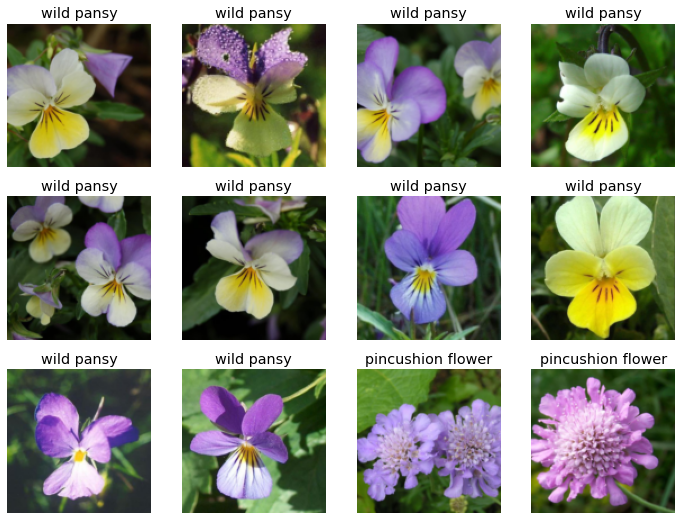

In [25]:
dls.valid.show_batch(max_n=12, nrows=3)

### 3.1 Training the first model

We will firs use the resnet18 architecture with basic settings of DataBlock.

In [11]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,3.276323,1.189829,0.316626,01:11


epoch,train_loss,valid_loss,error_rate,time
0,1.106526,0.561210,0.146699,01:19
1,0.572098,0.431747,0.113692,01:20


### 3.2 Second model - DataBlock parameters adjustment

In [26]:
train_flowers_2 = train_flowers.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls_2 = train_flowers_2.dataloaders('/content/flowers/flower_data')

In [ ]:
learn_2 = cnn_learner(dls_2, resnet18, metrics=error_rate)
learn_2.fine_tune(2)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,error_rate,time
0,2.907370,0.710203,0.166259,01:33


epoch,train_loss,valid_loss,error_rate,time
0,0.757677,0.291798,0.069682,01:56
1,0.425049,0.235197,0.056235,01:55


### 3.3 Third model - architecture adjustment

In [ ]:
learn_3 = cnn_learner(dls_2, resnet34, metrics=error_rate)
learn_3.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.938035,0.672177,0.173594,02:13


epoch,train_loss,valid_loss,error_rate,time
0,0.706831,0.263643,0.073350,03:07
1,0.348606,0.173547,0.046455,03:07


### 3.4 Second model with 4 additional epochs

In [ ]:
learn_2.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.305029,0.249341,0.068460,01:32


epoch,train_loss,valid_loss,error_rate,time
0,0.242974,0.192222,0.047677,01:55
1,0.192429,0.182058,0.042787,01:55
2,0.126087,0.162145,0.039120,01:55
3,0.081092,0.155453,0.040342,01:54


### 3.5  Third model with 4 additional epochs

In [ ]:
learn_3.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.238006,0.180990,0.047677,02:14


epoch,train_loss,valid_loss,error_rate,time
0,0.185948,0.189497,0.050122,03:07
1,0.163912,0.129783,0.029340,03:07
2,0.104363,0.112292,0.023227,03:07
3,0.060564,0.106264,0.025672,03:07


### 3.6 Fourth model - xresnet50 with 10 epochs

In [ ]:
learn_4 = cnn_learner(dls_2, xresnet50, metrics=error_rate)
learn_4.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,3.473444,2.638885,0.596577,03:03


epoch,train_loss,valid_loss,error_rate,time
0,2.078919,1.864171,0.453545,04:14
1,1.805401,1.542788,0.364303,04:14
2,1.490093,1.378081,0.344743,04:14
3,1.199127,1.102503,0.271394,04:14
4,0.980136,0.997087,0.254279,04:13
5,0.803296,0.885117,0.221271,04:14
6,0.653068,0.783052,0.177262,04:14
7,0.537171,0.747407,0.178484,04:14
8,0.448817,0.707086,0.167482,04:13
9,0.429132,0.678716,0.165037,04:14


### 3.7 Third model with 10 epochs in total

In [29]:
learn_4 = cnn_learner(dls_2, resnet34, metrics=error_rate)
learn_4.fine_tune(7)

epoch,train_loss,valid_loss,error_rate,time
0,2.860859,0.709947,0.172372,01:53


epoch,train_loss,valid_loss,error_rate,time
0,0.795334,0.300256,0.064792,02:33
1,0.450228,0.191567,0.051345,02:34
2,0.258584,0.155998,0.040342,02:33
3,0.144632,0.135322,0.044010,02:33
4,0.085217,0.099931,0.035452,02:33
5,0.048832,0.098344,0.026895,02:33
6,0.040980,0.092257,0.025672,02:33


### 4. The best model
The bes model so far is the resnet34 with 10 training epochs. We will save this model and make it availabele for online use.

First lets check the top 10 images with the highest loses.

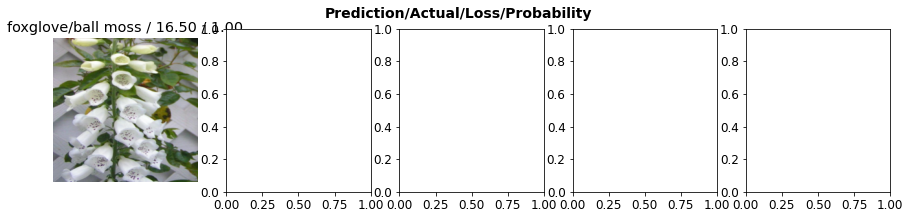

In [30]:
interp = ClassificationInterpretation.from_learner(learn_4)
interp.plot_top_losses(5, nrows=1)

### 5. Turning the best model into the production
We will try to create a working online application for this model.

In [31]:
#Firs we export the model as Pickle file
learn_4.export()

In [5]:
#We can try and load our inference
learn_inf = load_learner('/content/drive/MyDrive/Colab Notebooks/export.pkl')

In [6]:
#Let's try if the inference works
learn_inf.predict('/content/drive/MyDrive/Colab Notebooks/Red eagle.jpg')

('rose',
 TensorBase(78),
 TensorBase([3.5489e-09, 1.0209e-06, 6.7359e-09, 8.7800e-08, 1.4297e-07, 1.8177e-07, 1.3979e-06, 5.8350e-07, 6.6321e-08, 2.0820e-06, 7.3703e-07, 1.0733e-08, 1.3625e-07, 1.5902e-07, 3.1131e-09, 9.5408e-08,
         2.7403e-07, 3.3789e-09, 3.3210e-08, 4.3119e-07, 7.4585e-09, 1.2450e-08, 3.8245e-06, 1.2260e-07, 5.4110e-08, 1.7180e-08, 3.6768e-08, 2.7905e-08, 1.2517e-08, 1.2176e-07, 7.3663e-07, 2.4140e-08,
         2.0134e-08, 1.6374e-08, 8.0999e-06, 1.7522e-08, 7.3689e-08, 3.4263e-07, 5.1155e-09, 3.0858e-09, 5.1383e-07, 4.2028e-07, 2.8168e-07, 1.5021e-07, 1.5062e-06, 3.5442e-09, 3.0924e-08, 2.7750e-08,
         2.5208e-08, 1.9095e-08, 7.1126e-09, 1.6675e-08, 1.0731e-08, 1.7026e-07, 1.4466e-08, 1.1660e-07, 4.8732e-08, 3.8169e-08, 4.5099e-07, 7.5468e-09, 2.7026e-08, 1.0355e-07, 1.2399e-06, 1.3942e-07,
         4.5133e-08, 1.8921e-07, 1.9519e-07, 2.4372e-08, 2.3218e-08, 5.5210e-08, 2.0392e-09, 1.3603e-07, 5.5720e-06, 3.1129e-08, 6.6655e-09, 3.9757e-08, 5.2205e-07, 5

In [7]:
#we can also check all categories in the inference
learn_inf.dls.vocab

['alpine sea holly', 'anthurium', 'artichoke', 'azalea', 'ball moss', 'balloon flower', 'barbeton daisy', 'bearded iris', 'bee balm', 'bird of paradise', 'bishop of llandaff', 'black-eyed susan', 'blackberry lily', 'blanket flower', 'bolero deep blue', 'bougainvillea', 'bromelia', 'buttercup', 'californian poppy', 'camellia', 'canna lily', 'canterbury bells', 'cape flower', 'carnation', 'cautleya spicata', 'clematis', "colt's foot", 'columbine', 'common dandelion', 'corn poppy', 'cyclamen', 'daffodil', 'desert-rose', 'english marigold', 'fire lily', 'foxglove', 'frangipani', 'fritillary', 'garden phlox', 'gaura', 'gazania', 'geranium', 'giant white arum lily', 'globe thistle', 'globe-flower', 'grape hyacinth', 'great masterwort', 'hard-leaved pocket orchid', 'hibiscus', 'hippeastrum', 'japanese anemone', 'king protea', 'lenten rose', 'lotus lotus', 'love in the mist', 'magnolia', 'mallow', 'marigold', 'mexican aster', 'mexican petunia', 'monkshood', 'moon orchid', 'morning glory', 'ora

Lets now creat an online application using IPython widgets and Voila

In [27]:
btn = widgets.FileUpload()
btn

FileUpload(value={}, description='Upload')

In [29]:
img = PILImage.create(btn.data[-1])
out = widgets.Output()
out.clear_output()
with out: display(img.to_thumb(224,224))
out

IndexError: ignored

In [20]:
pred,pred_idx,probs = learn_inf.predict(img)
lbl = widgets.Label()
lbl.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.02f}'
lbl

Label(value='Prediction: rose; Probability: 1.00')

In [24]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [25]:
def on_click_classify(change):
  img = PILImage.create(btn.data[-1])
  out.clear_output()
  with out: display(img.to_thumb(224,224))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.02f}'

btn_run.on_click(on_click_classify)

In [30]:
VBox([widgets.Label('Select your flower!'), btn, btn_run, out, lbl])

Now we will create a new nootebook containing only the widgets.